# Model with the error correctness and without Green data (Xout)

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
from keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [52]:
# loading the data
df = pd.read_excel("103_upset (around 21000 points).xls", header= 3)
df.head(6)

,Time,,Flow,Flow.1,Flow.2,Flow.3,Flow.4,Flow.5,Press,Press.1,...,Press.4,Press.5,Press.6,Press.7,Temp,Temp.1,Temp.2,Temp.3,Temp.4,oxygen
0,NaN,NaN,BFW,BFW,Steam,Steam,Fuel gas,Air,FD disch,Fuel gas,...,ignitor,steam drm,steam drm,flue gas,Dertor,steam drm,super,super,flue gas,%
1,NaN,,92fi300.pv,92fy300.pv,92fi301.pv,92fi301.pv,92fi305.pv,92fi302.pv,92pi317.pv,92pi311.pv,...,92pi324.pv,92pi307.pv,92pi301.pv,92pi300.pv,93ti211.pv,92ti300a.pv,92ti300b.pv,92ti311.pv,92ti300.pv,92ai300.pv
2,NaN,2008-06-21 07:00:00,355.848491,355.234993,352.095325,352.095325,401.596232,1.12351,9.716322,7.576174,...,7.780427,628.271028,649.402659,0.310961,298.276672,597.732324,760.399808,765.36439,335.989723,2.05269
3,NaN,2008-06-21 07:00:01,355.877026,355.345775,354.608066,354.608066,401.471854,1.111719,9.716363,7.576189,...,7.780427,628.270974,649.402513,0.310964,298.276689,597.732295,760.399987,765.36489,335.989571,2.030534
4,NaN,2008-06-21 07:00:02,355.90556,355.456557,356.111179,356.111179,401.347476,1.099927,9.716405,7.576205,...,7.780427,628.270921,649.402367,0.310968,298.276707,597.732267,760.400165,765.36539,335.989419,2.018448
5,NaN,2008-06-21 07:00:03,355.934095,355.567339,356.604663,356.604663,401.223098,1.088136,9.716447,7.57622,...,7.780428,628.270868,649.402221,0.310972,298.276724,597.732239,760.400343,765.36589,335.989267,2.016434


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21602 entries, 0 to 21601
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     0 non-null      float64
 1            21601 non-null  object 
 2   Flow     21602 non-null  object 
 3   Flow.1   21602 non-null  object 
 4   Flow.2   21602 non-null  object 
 5   Flow.3   21602 non-null  object 
 6   Flow.4   21602 non-null  object 
 7   Flow.5   21602 non-null  object 
 8   Press    21602 non-null  object 
 9   Press.1  21602 non-null  object 
 10  Press.2  21602 non-null  object 
 11  Press.3  21602 non-null  object 
 12  Press.4  21602 non-null  object 
 13  Press.5  21602 non-null  object 
 14  Press.6  21602 non-null  object 
 15  Press.7  21602 non-null  object 
 16  Temp     21602 non-null  object 
 17  Temp.1   21602 non-null  object 
 18  Temp.2   21602 non-null  object 
 19  Temp.3   21602 non-null  object 
 20  Temp.4   21602 non-null  object 
 21  oxygen   216

# Preprocessing

In [54]:
#Droping First colmun and First two rows
df=df.drop([0,1], axis=0)
df = df.drop(df.iloc[:,0:1],axis = 1)

In [55]:
df.head()

,,Flow,Flow.1,Flow.2,Flow.3,Flow.4,Flow.5,Press,Press.1,Press.2,...,Press.4,Press.5,Press.6,Press.7,Temp,Temp.1,Temp.2,Temp.3,Temp.4,oxygen
2,2008-06-21 07:00:00,355.848491,355.234993,352.095325,352.095325,401.596232,1.12351,9.716322,7.576174,0.008244,...,7.780427,628.271028,649.402659,0.310961,298.276672,597.732324,760.399808,765.36439,335.989723,2.05269
3,2008-06-21 07:00:01,355.877026,355.345775,354.608066,354.608066,401.471854,1.111719,9.716363,7.576189,0.008244,...,7.780427,628.270974,649.402513,0.310964,298.276689,597.732295,760.399987,765.36489,335.989571,2.030534
4,2008-06-21 07:00:02,355.90556,355.456557,356.111179,356.111179,401.347476,1.099927,9.716405,7.576205,0.008245,...,7.780427,628.270921,649.402367,0.310968,298.276707,597.732267,760.400165,765.36539,335.989419,2.018448
5,2008-06-21 07:00:03,355.934095,355.567339,356.604663,356.604663,401.223098,1.088136,9.716447,7.57622,0.008245,...,7.780428,628.270868,649.402221,0.310972,298.276724,597.732239,760.400343,765.36589,335.989267,2.016434
6,2008-06-21 07:00:04,355.96263,355.678121,355.491806,355.491806,401.09872,1.083197,9.716489,7.576236,0.008246,...,7.780428,628.270815,649.402075,0.310976,298.276742,597.73221,760.400521,765.366391,335.989115,2.01442


In [56]:
colWithTime=['Time','Flow BFW/ 92fi300.pv', 'Flow BFW/92fy300.pv','Flow Steam/92fi301.pv', 'Flow Steam/92fi301.pv.1', 'Flow Fuel gas/92fi305.pv', 'Flow Air/92fi302.pv', 'Press FD disch/92pi317.pv', 'Press Fuel gas/92pi311.pv', 'Press Fuel gas/92pi304.pv', 'Press furnce/92pi306.pv', 'Press ignitor /92pi324.pv','Press steam drm/92pi307.pv', 'Press steam drm/92pi301.pv','Press flue gas/92pi300.pv','Temp Dertor /93ti211.pv','Temp steam drm/92ti300a.pv','Temp super/92ti300b.pv','Temp super/92ti311.pv','Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv']
df.columns = colWithTime
col=['Flow BFW/ 92fi300.pv', 'Flow BFW/92fy300.pv','Flow Steam/92fi301.pv', 'Flow Steam/92fi301.pv.1', 'Flow Fuel gas/92fi305.pv', 'Flow Air/92fi302.pv', 'Press FD disch/92pi317.pv', 'Press Fuel gas/92pi311.pv', 'Press Fuel gas/92pi304.pv', 'Press furnce/92pi306.pv', 'Press ignitor /92pi324.pv','Press steam drm/92pi307.pv', 'Press steam drm/92pi301.pv','Press flue gas/92pi300.pv','Temp Dertor /93ti211.pv','Temp steam drm/92ti300a.pv','Temp super/92ti300b.pv','Temp super/92ti311.pv','Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv']
df[col] = df[col].apply(pd.to_numeric, errors= 'coerce', downcast= 'float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 2 to 21601
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Time                        21600 non-null  object 
 1   Flow BFW/ 92fi300.pv        21510 non-null  float32
 2   Flow BFW/92fy300.pv         21582 non-null  float32
 3   Flow Steam/92fi301.pv       21582 non-null  float32
 4   Flow Steam/92fi301.pv.1     21582 non-null  float32
 5   Flow Fuel gas/92fi305.pv    21582 non-null  float32
 6   Flow Air/92fi302.pv         21582 non-null  float32
 7   Press FD disch/92pi317.pv   21582 non-null  float32
 8   Press Fuel gas/92pi311.pv   21582 non-null  float32
 9   Press Fuel gas/92pi304.pv   21582 non-null  float32
 10  Press furnce/92pi306.pv     21582 non-null  float32
 11  Press ignitor /92pi324.pv   21582 non-null  float32
 12  Press steam drm/92pi307.pv  21582 non-null  float32
 13  Press steam drm/92pi301.pv  215

In [57]:
# filling the null values of Press flue gas/92pi300.pv by the mean value
df['Press flue gas/92pi300.pv']= df['Press flue gas/92pi300.pv'].fillna(df['Press flue gas/92pi300.pv'].mean())
df['Press flue gas/92pi300.pv'].describe()

count    21600.000000
mean         0.335788
std          0.032409
min          0.276383
25%          0.308812
50%          0.335786
75%          0.361206
max          0.418377
Name: Press flue gas/92pi300.pv, dtype: float64

In [58]:
df['Time']= df['Time'].apply(pd.to_datetime ,errors= 'coerce' )

# dropping features marked us not needed for the model (Black)
df = df.drop("Flow BFW/92fy300.pv",axis = 1)
df = df.drop("Flow Steam/92fi301.pv",axis = 1)
df = df.drop("Temp super/92ti311.pv",axis = 1)

In [59]:
colToBeDropped = ['Press FD disch/92pi317.pv', 'Press Fuel gas/92pi311.pv','Press furnce/92pi306.pv', 'Press ignitor /92pi324.pv','Press steam drm/92pi307.pv', 'Press steam drm/92pi301.pv','Temp Dertor /93ti211.pv','Temp steam drm/92ti300a.pv','Temp super/92ti300b.pv']
df = df.drop(colToBeDropped,axis = 1)

In [60]:
display(df)

,Time,Flow BFW/ 92fi300.pv,Flow Steam/92fi301.pv.1,Flow Fuel gas/92fi305.pv,Flow Air/92fi302.pv,Press Fuel gas/92pi304.pv,Press flue gas/92pi300.pv,Temp flue gas/92ti300.pv,oxygen% /92ai300.pv
2,2008-06-21 07:00:00,355.848480,352.095337,401.596222,1.123510,0.008244,0.310961,335.989716,2.052690
3,2008-06-21 07:00:01,355.877014,354.608063,401.471863,1.111719,0.008244,0.310964,335.989563,2.030534
4,2008-06-21 07:00:02,355.905548,356.111176,401.347473,1.099927,0.008245,0.310968,335.989410,2.018448
5,2008-06-21 07:00:03,355.934082,356.604675,401.223083,1.088136,0.008245,0.310972,335.989258,2.016434
6,2008-06-21 07:00:04,355.962616,355.491791,401.098724,1.083197,0.008246,0.310976,335.989105,2.014420
...,...,...,...,...,...,...,...,...,...
21597,2008-06-21 12:59:55,355.894012,355.310516,384.652435,1.079072,0.050951,0.317213,355.115173,1.953448
21598,2008-06-21 12:59:56,355.618317,354.761658,384.477875,1.083946,0.050951,0.319882,355.113800,1.955882
21599,2008-06-21 12:59:57,355.342621,356.987366,383.877808,1.085681,0.050951,0.322551,355.112396,1.958315
21600,2008-06-21 12:59:58,355.066925,356.524109,384.063263,1.087415,0.050951,0.325220,355.111023,1.960749


In [61]:
df = df.dropna()

In [62]:
df.index = df.pop('Time')
df.head()

,Flow BFW/ 92fi300.pv,Flow Steam/92fi301.pv.1,Flow Fuel gas/92fi305.pv,Flow Air/92fi302.pv,Press Fuel gas/92pi304.pv,Press flue gas/92pi300.pv,Temp flue gas/92ti300.pv,oxygen% /92ai300.pv
Time,,,,,,,,
2008-06-21 07:00:00,355.848480,352.095337,401.596222,1.123510,0.008244,0.310961,335.989716,2.052690
2008-06-21 07:00:01,355.877014,354.608063,401.471863,1.111719,0.008244,0.310964,335.989563,2.030534
2008-06-21 07:00:02,355.905548,356.111176,401.347473,1.099927,0.008245,0.310968,335.989410,2.018448
2008-06-21 07:00:03,355.934082,356.604675,401.223083,1.088136,0.008245,0.310972,335.989258,2.016434
2008-06-21 07:00:04,355.962616,355.491791,401.098724,1.083197,0.008246,0.310976,335.989105,2.014420


# LSTM data preperation

In [63]:
# defining the input columns
# PFG = df.drop(['Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv','Press Fuel gas/92pi304.pv','Press flue gas/92pi300.pv'], axis=1)
# PFG.shape

In [64]:
# defining the output columns
# ypf1= df[['Temp flue gas/92ti300.pv']]
# ypf1= ypf1.to_numpy()
# ypf1= ypf1.reshape(-1,1)

# ypf2= df[['oxygen% /92ai300.pv']]
# ypf2= ypf2.to_numpy()
# ypf2= ypf2.reshape(-1,1)

# ypf3= df[['Press Fuel gas/92pi304.pv']]
# ypf3= ypf3.to_numpy()
# ypf3= ypf3.reshape(-1,1)

# ypf4= df[['Press flue gas/92pi300.pv']]
# ypf4= ypf4.to_numpy()
# ypf4= ypf4.reshape(-1,1)

In [65]:
# from sklearn.preprocessing import StandardScaler


# s =StandardScaler()
# s2 =StandardScaler()
# s= s.fit(PFG)
# s2= s2.fit(ypf1)
# s2= s2.fit(ypf2)
# s2= s2.fit(ypf3)
# s2= s2.fit(ypf4)

# PFG= s.transform(PFG)
# ypf1=s2.transform(ypf1)
# ypf2=s2.transform(ypf2) 
# ypf3=s2.transform(ypf3) 
# ypf4=s2.transform(ypf4) 

# PFG = pd.DataFrame(PFG)
# PFG['12'] = ypf1
# PFG['13'] = ypf2
# PFG['14'] = ypf3
# PFG['15'] = ypf4
# display(PFG)
# PFG= PFG.to_numpy()

In [66]:
# reshaping the data

# X= []
# y= []
# n1= 1
# n2= 10
# for i in range(n2, len(PFG)-n1 +1):
#     X.append(PFG[i-n2 : i, 0: PFG.shape[1]])
#     y.append(PFG[i+n1-1:i+n1,12:16])
    

In [67]:
# X, y =np.array(X), np.array(y)
# X.shape , y.shape

In [68]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

# Model data preperation


In [69]:
train, test = train_test_split(df, test_size=0.2, random_state = 1)
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [70]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def format_output(data):
    y1 = data.pop("Press Fuel gas/92pi304.pv")
    y1 = np.array(y1)
    y2 = data.pop('Press flue gas/92pi300.pv')
    y2 = np.array(y2)
    y3 = data.pop('Temp flue gas/92ti300.pv')
    y3 = np.array(y3)
    y4 = data.pop('oxygen% /92ai300.pv')
    y4 = np.array(y4)
    
    return y1, y2, y3, y4

In [71]:
# Get the 4 outputs and format them as np arrays

train_stats = train.describe()
train_stats.pop('Press Fuel gas/92pi304.pv')
train_stats.pop('Press flue gas/92pi300.pv')
train_stats.pop('Temp flue gas/92ti300.pv')
train_stats.pop('oxygen% /92ai300.pv')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)
val_Y = format_output(val)

print(train_stats)

                            count        mean        std         min  \
Flow BFW/ 92fi300.pv      13766.0  396.048737  45.507866  310.567108   
Flow Steam/92fi301.pv.1   13766.0  397.125854  45.138466  338.026001   
Flow Fuel gas/92fi305.pv  13766.0  435.481720  43.873665  366.159363   
Flow Air/92fi302.pv       13766.0    1.381090   0.331331    0.999671   

                                 25%         50%         75%         max  
Flow BFW/ 92fi300.pv      367.313400  378.983917  409.170387  608.264893  
Flow Steam/92fi301.pv.1   366.766418  376.449768  431.428368  570.761719  
Flow Fuel gas/92fi305.pv  410.000626  419.999741  459.013397  662.776794  
Flow Air/92fi302.pv         1.170792    1.221842    1.576584    2.908824  


In [72]:
# Normalize the training and test data
norm_train_X = np.array(norm(train))
norm_test_X = np.array(norm(test))
norm_val_X = np.array(norm(val))

In [73]:
norm_test_X

array([[-0.29111688, -0.4672066 , -0.34163408, -0.5455134 ],
       [ 0.57980552,  0.23990309, -0.14632955,  0.14745069],
       [-0.63405103, -0.61820005, -0.49442833, -0.59851614],
       ...,
       [ 2.9106987 ,  1.66477694,  1.38542753,  1.47910932],
       [ 0.26634961,  1.84405048,  2.36073849,  2.82520631],
       [-0.56566793, -0.57932229, -0.41592603, -0.60345569]])

# Modeling

In [74]:
# # #Model with 4 layers including the output column
# def build_model():
#     # Define model layers.
#     input_layer = Input(shape=(len(train .columns),))
    
#     #lstm_layer = LSTM(128)(input_layer)
#     hidden1 = Dense(128, activation='relu')(input_layer)
#     hidden2 = Dense(128, activation='relu')(hidden1)
    
#     #(lstm_layer)
#     y1_output = Dense(units='1', name='PressFuelGas304_output')(hidden2)
#     y2_output = Dense(units='1', name='PressFlueGas300_output')(hidden2)
#     y3_output = Dense(units='1', name='TempFlueGas_output')(hidden2)
#     y4_output = Dense(units='1', name='Oxygen_output')(hidden2)
    
#     # Define the model with the input layer and a list of output layers
#     model = Model(inputs=input_layer, outputs=[y1_output, y2_output,y3_output,y4_output])
#     return model

In [86]:
#Model with 5 layers including the output column
def build_model():
    # Define model layers.
    input_layer = Input(shape=(len(train .columns),))
    
    # 5L 
#     hidden1 = Dense(128, activation='relu')(input_layer)
#     hidden2 = Dense(128, activation='relu')(hidden1)
#     hidden3 = Dense(64, activation='relu')(hidden2)


    # 5L 128/64/32
    hidden1 = Dense(128, activation='relu')(input_layer)
    hidden2 = Dense(64, activation='relu')(hidden1)
    hidden3 = Dense(32, activation='relu')(hidden2)
    

    #(lstm_layer)
    y1_output = Dense(units='1', name='PressFuelGas304_output')(hidden3)
    y2_output = Dense(units='1', name='PressFlueGas300_output')(hidden3)
    y3_output = Dense(units='1', name='TempFlueGas_output')(hidden3)
    y4_output = Dense(units='1', name='Oxygen_output')(hidden3)
    
    # Define the model with the input layer and a list of output layers
    model = Model(inputs=input_layer, outputs=[y1_output, y2_output,y3_output,y4_output])
    return model

In [87]:
model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'PressFuelGas304_output': 'mse', 'PressFlueGas300_output': 'mse','TempFlueGas_output': 'mse','Oxygen_output': 'mse'},
              metrics={'PressFuelGas304_output': tf.keras.metrics.RootMeanSquaredError(),
                       'PressFlueGas300_output': tf.keras.metrics.RootMeanSquaredError(),
                       'TempFlueGas_output': tf.keras.metrics.RootMeanSquaredError(),
                       'Oxygen_output': tf.keras.metrics.RootMeanSquaredError()})

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 128)          640         ['input_3[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 64)           8256        ['dense_5[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 32)           2080        ['dense_6[0][0]']                
                                                                                            

In [88]:
# Train the model for 50 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=100, batch_size=32, validation_data=(norm_test_X, test_Y))

Epoch 1/100
431/431 [==============================] - 8s 7ms/step - loss: 118156.9609 - PressFuelGas304_output_loss: 0.2818 - PressFlueGas300_output_loss: 0.1219 - TempFlueGas_output_loss: 118152.3125 - Oxygen_output_loss: 4.2662 - PressFuelGas304_output_root_mean_squared_error: 0.5308 - PressFlueGas300_output_root_mean_squared_error: 0.3491 - TempFlueGas_output_root_mean_squared_error: 343.7329 - Oxygen_output_root_mean_squared_error: 2.0655 - val_loss: 105796.8906 - val_PressFuelGas304_output_loss: 0.3962 - val_PressFlueGas300_output_loss: 0.0375 - val_TempFlueGas_output_loss: 105795.7109 - val_Oxygen_output_loss: 0.7129 - val_PressFuelGas304_output_root_mean_squared_error: 0.6294 - val_PressFlueGas300_output_root_mean_squared_error: 0.1938 - val_TempFlueGas_output_root_mean_squared_error: 325.2625 - val_Oxygen_output_root_mean_squared_error: 0.8443
Epoch 2/100
431/431 [==============================] - 2s 5ms/step - loss: 66025.8438 - PressFuelGas304_output_loss: 0.6611 - PressFlue

Epoch 11/100
431/431 [==============================] - 2s 5ms/step - loss: 641.9466 - PressFuelGas304_output_loss: 0.0287 - PressFlueGas300_output_loss: 0.0238 - TempFlueGas_output_loss: 641.8247 - Oxygen_output_loss: 0.0694 - PressFuelGas304_output_root_mean_squared_error: 0.1694 - PressFlueGas300_output_root_mean_squared_error: 0.1543 - TempFlueGas_output_root_mean_squared_error: 25.3343 - Oxygen_output_root_mean_squared_error: 0.2634 - val_loss: 472.8938 - val_PressFuelGas304_output_loss: 0.0277 - val_PressFlueGas300_output_loss: 0.0281 - val_TempFlueGas_output_loss: 472.7665 - val_Oxygen_output_loss: 0.0716 - val_PressFuelGas304_output_root_mean_squared_error: 0.1665 - val_PressFlueGas300_output_root_mean_squared_error: 0.1678 - val_TempFlueGas_output_root_mean_squared_error: 21.7432 - val_Oxygen_output_root_mean_squared_error: 0.2676
Epoch 12/100
431/431 [==============================] - 2s 5ms/step - loss: 395.3726 - PressFuelGas304_output_loss: 0.0309 - PressFlueGas300_output_

Epoch 21/100
431/431 [==============================] - 2s 5ms/step - loss: 24.2535 - PressFuelGas304_output_loss: 0.0177 - PressFlueGas300_output_loss: 0.0281 - TempFlueGas_output_loss: 24.1016 - Oxygen_output_loss: 0.1061 - PressFuelGas304_output_root_mean_squared_error: 0.1332 - PressFlueGas300_output_root_mean_squared_error: 0.1677 - TempFlueGas_output_root_mean_squared_error: 4.9093 - Oxygen_output_root_mean_squared_error: 0.3257 - val_loss: 23.0408 - val_PressFuelGas304_output_loss: 0.0171 - val_PressFlueGas300_output_loss: 0.0255 - val_TempFlueGas_output_loss: 22.9104 - val_Oxygen_output_loss: 0.0877 - val_PressFuelGas304_output_root_mean_squared_error: 0.1308 - val_PressFlueGas300_output_root_mean_squared_error: 0.1597 - val_TempFlueGas_output_root_mean_squared_error: 4.7865 - val_Oxygen_output_root_mean_squared_error: 0.2962
Epoch 22/100
431/431 [==============================] - 2s 5ms/step - loss: 21.5737 - PressFuelGas304_output_loss: 0.0160 - PressFlueGas300_output_loss: 0

Epoch 31/100
431/431 [==============================] - 2s 5ms/step - loss: 14.8175 - PressFuelGas304_output_loss: 0.0083 - PressFlueGas300_output_loss: 0.0073 - TempFlueGas_output_loss: 14.7713 - Oxygen_output_loss: 0.0307 - PressFuelGas304_output_root_mean_squared_error: 0.0909 - PressFlueGas300_output_root_mean_squared_error: 0.0851 - TempFlueGas_output_root_mean_squared_error: 3.8433 - Oxygen_output_root_mean_squared_error: 0.1751 - val_loss: 14.4997 - val_PressFuelGas304_output_loss: 0.0080 - val_PressFlueGas300_output_loss: 0.0068 - val_TempFlueGas_output_loss: 14.4573 - val_Oxygen_output_loss: 0.0277 - val_PressFuelGas304_output_root_mean_squared_error: 0.0894 - val_PressFlueGas300_output_root_mean_squared_error: 0.0822 - val_TempFlueGas_output_root_mean_squared_error: 3.8023 - val_Oxygen_output_root_mean_squared_error: 0.1665
Epoch 32/100
431/431 [==============================] - 2s 5ms/step - loss: 14.5307 - PressFuelGas304_output_loss: 0.0077 - PressFlueGas300_output_loss: 0

Epoch 41/100
431/431 [==============================] - 2s 5ms/step - loss: 12.7055 - PressFuelGas304_output_loss: 0.0046 - PressFlueGas300_output_loss: 0.0038 - TempFlueGas_output_loss: 12.6684 - Oxygen_output_loss: 0.0287 - PressFuelGas304_output_root_mean_squared_error: 0.0681 - PressFlueGas300_output_root_mean_squared_error: 0.0620 - TempFlueGas_output_root_mean_squared_error: 3.5593 - Oxygen_output_root_mean_squared_error: 0.1693 - val_loss: 12.4512 - val_PressFuelGas304_output_loss: 0.0044 - val_PressFlueGas300_output_loss: 0.0041 - val_TempFlueGas_output_loss: 12.4171 - val_Oxygen_output_loss: 0.0257 - val_PressFuelGas304_output_root_mean_squared_error: 0.0662 - val_PressFlueGas300_output_root_mean_squared_error: 0.0636 - val_TempFlueGas_output_root_mean_squared_error: 3.5238 - val_Oxygen_output_root_mean_squared_error: 0.1603
Epoch 42/100
431/431 [==============================] - 2s 5ms/step - loss: 12.5696 - PressFuelGas304_output_loss: 0.0045 - PressFlueGas300_output_loss: 0

Epoch 51/100
431/431 [==============================] - 2s 5ms/step - loss: 11.6420 - PressFuelGas304_output_loss: 0.0042 - PressFlueGas300_output_loss: 0.0022 - TempFlueGas_output_loss: 11.6075 - Oxygen_output_loss: 0.0281 - PressFuelGas304_output_root_mean_squared_error: 0.0645 - PressFlueGas300_output_root_mean_squared_error: 0.0468 - TempFlueGas_output_root_mean_squared_error: 3.4070 - Oxygen_output_root_mean_squared_error: 0.1677 - val_loss: 11.6230 - val_PressFuelGas304_output_loss: 0.0038 - val_PressFlueGas300_output_loss: 0.0020 - val_TempFlueGas_output_loss: 11.5903 - val_Oxygen_output_loss: 0.0270 - val_PressFuelGas304_output_root_mean_squared_error: 0.0613 - val_PressFlueGas300_output_root_mean_squared_error: 0.0445 - val_TempFlueGas_output_root_mean_squared_error: 3.4044 - val_Oxygen_output_root_mean_squared_error: 0.1643
Epoch 52/100
431/431 [==============================] - 2s 4ms/step - loss: 11.5582 - PressFuelGas304_output_loss: 0.0042 - PressFlueGas300_output_loss: 0

Epoch 61/100
431/431 [==============================] - 2s 5ms/step - loss: 10.9837 - PressFuelGas304_output_loss: 0.0043 - PressFlueGas300_output_loss: 0.0018 - TempFlueGas_output_loss: 10.9495 - Oxygen_output_loss: 0.0281 - PressFuelGas304_output_root_mean_squared_error: 0.0657 - PressFlueGas300_output_root_mean_squared_error: 0.0419 - TempFlueGas_output_root_mean_squared_error: 3.3090 - Oxygen_output_root_mean_squared_error: 0.1677 - val_loss: 10.8009 - val_PressFuelGas304_output_loss: 0.0040 - val_PressFlueGas300_output_loss: 0.0016 - val_TempFlueGas_output_loss: 10.7701 - val_Oxygen_output_loss: 0.0252 - val_PressFuelGas304_output_root_mean_squared_error: 0.0630 - val_PressFlueGas300_output_root_mean_squared_error: 0.0401 - val_TempFlueGas_output_root_mean_squared_error: 3.2818 - val_Oxygen_output_root_mean_squared_error: 0.1588
Epoch 62/100
431/431 [==============================] - 2s 5ms/step - loss: 11.0225 - PressFuelGas304_output_loss: 0.0043 - PressFlueGas300_output_loss: 0

Epoch 71/100
431/431 [==============================] - 2s 4ms/step - loss: 10.5399 - PressFuelGas304_output_loss: 0.0045 - PressFlueGas300_output_loss: 0.0018 - TempFlueGas_output_loss: 10.5071 - Oxygen_output_loss: 0.0265 - PressFuelGas304_output_root_mean_squared_error: 0.0673 - PressFlueGas300_output_root_mean_squared_error: 0.0425 - TempFlueGas_output_root_mean_squared_error: 3.2415 - Oxygen_output_root_mean_squared_error: 0.1627 - val_loss: 10.6703 - val_PressFuelGas304_output_loss: 0.0042 - val_PressFlueGas300_output_loss: 0.0023 - val_TempFlueGas_output_loss: 10.6399 - val_Oxygen_output_loss: 0.0239 - val_PressFuelGas304_output_root_mean_squared_error: 0.0651 - val_PressFlueGas300_output_root_mean_squared_error: 0.0482 - val_TempFlueGas_output_root_mean_squared_error: 3.2619 - val_Oxygen_output_root_mean_squared_error: 0.1545
Epoch 72/100
431/431 [==============================] - 2s 5ms/step - loss: 10.5061 - PressFuelGas304_output_loss: 0.0044 - PressFlueGas300_output_loss: 0

Epoch 81/100
431/431 [==============================] - 2s 5ms/step - loss: 10.2959 - PressFuelGas304_output_loss: 0.0045 - PressFlueGas300_output_loss: 0.0017 - TempFlueGas_output_loss: 10.2642 - Oxygen_output_loss: 0.0256 - PressFuelGas304_output_root_mean_squared_error: 0.0669 - PressFlueGas300_output_root_mean_squared_error: 0.0409 - TempFlueGas_output_root_mean_squared_error: 3.2038 - Oxygen_output_root_mean_squared_error: 0.1599 - val_loss: 10.2322 - val_PressFuelGas304_output_loss: 0.0047 - val_PressFlueGas300_output_loss: 0.0015 - val_TempFlueGas_output_loss: 10.2033 - val_Oxygen_output_loss: 0.0227 - val_PressFuelGas304_output_root_mean_squared_error: 0.0685 - val_PressFlueGas300_output_root_mean_squared_error: 0.0390 - val_TempFlueGas_output_root_mean_squared_error: 3.1943 - val_Oxygen_output_root_mean_squared_error: 0.1507
Epoch 82/100
431/431 [==============================] - 2s 5ms/step - loss: 10.2447 - PressFuelGas304_output_loss: 0.0045 - PressFlueGas300_output_loss: 0

Epoch 91/100
431/431 [==============================] - 2s 5ms/step - loss: 10.0627 - PressFuelGas304_output_loss: 0.0047 - PressFlueGas300_output_loss: 0.0017 - TempFlueGas_output_loss: 10.0318 - Oxygen_output_loss: 0.0245 - PressFuelGas304_output_root_mean_squared_error: 0.0686 - PressFlueGas300_output_root_mean_squared_error: 0.0413 - TempFlueGas_output_root_mean_squared_error: 3.1673 - Oxygen_output_root_mean_squared_error: 0.1564 - val_loss: 9.9879 - val_PressFuelGas304_output_loss: 0.0054 - val_PressFlueGas300_output_loss: 0.0015 - val_TempFlueGas_output_loss: 9.9591 - val_Oxygen_output_loss: 0.0218 - val_PressFuelGas304_output_root_mean_squared_error: 0.0737 - val_PressFlueGas300_output_root_mean_squared_error: 0.0388 - val_TempFlueGas_output_root_mean_squared_error: 3.1558 - val_Oxygen_output_root_mean_squared_error: 0.1478
Epoch 92/100
431/431 [==============================] - 2s 5ms/step - loss: 9.9560 - PressFuelGas304_output_loss: 0.0045 - PressFlueGas300_output_loss: 0.00

# Results of the model without timesteps

In [78]:
# Test the model and print loss and rmse for ALL outputs
loss, Y1_loss, Y2_loss,Y3_loss, Y4_loss, Y1_rmse, Y2_rmse, Y3_rmse, Y4_rmse = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'PressFuelGas304_loss: {Y1_loss}')
print(f'PressFlueGas300_loss: {Y2_loss}')
print(f'TempFlueGas_loss: {Y3_loss}')
print(f'Oxygen_loss: {Y4_loss}')
print(f'PressFuelGas304_rmse: {Y1_rmse}')
print(f'PressFlueGas300_rmse: {Y2_rmse}')
print(f'TempFlueGas_rmse: {Y3_rmse}')
print(f'Oxygen_rmse: {Y4_rmse}')

108/108 [==============================] - 0s 4ms/step - loss: 9.2937 - PressFuelGas304_output_loss: 0.0019 - PressFlueGas300_output_loss: 0.0012 - TempFlueGas_output_loss: 9.2710 - Oxygen_output_loss: 0.0197 - PressFuelGas304_output_root_mean_squared_error: 0.0433 - PressFlueGas300_output_root_mean_squared_error: 0.0341 - TempFlueGas_output_root_mean_squared_error: 3.0448 - Oxygen_output_root_mean_squared_error: 0.1404

loss: 9.293708801269531
PressFuelGas304_loss: 0.0018763861153274775
PressFlueGas300_loss: 0.0011642759200185537
TempFlueGas_loss: 9.270959854125977
Oxygen_loss: 0.01970660872757435
PressFuelGas304_rmse: 0.0433172732591629
PressFlueGas300_rmse: 0.03412148728966713
TempFlueGas_rmse: 3.0448250770568848
Oxygen_rmse: 0.14038023352622986


<!-- # 4 layers
![image.png](attachment:image.png)

# 5 layers
![image-2.png](attachment:image-2.png)

# 5 layers 128 - 64 - 32 nodes in hidden layers
![image-3.png](attachment:image-3.png) -->

In [89]:
# Run predict
Y_pred = model.predict(norm_test_X)

135/135 [==============================] - 1s 3ms/step


In [80]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [90]:
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

def maxMape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.max(np.abs((y_test - pred) / y_test))
    return mape

In [91]:
print(F"The MAPE value of Press Fuel gas/92pi304 {mape(test_Y[0],Y_pred[0])}")
print(F"The MAPE value of Press Fuel gas/92pi300 {mape(test_Y[1],Y_pred[1])}")
print(F"The MAPE value of Temp flue gas {mape(test_Y[2],Y_pred[2])}")
print(F"The MAPE value of oxygen% {mape(test_Y[3],Y_pred[3])}")

The MAPE value of Press Fuel gas/92pi304 2.569056749343872
The MAPE value of Press Fuel gas/92pi300 0.1194135844707489
The MAPE value of Temp flue gas 0.029814686626195908
The MAPE value of oxygen% 0.0579158179461956


In [84]:
print(F"The Max MAPE value of Press Fuel gas/92pi304 {maxMape(test_Y[0],Y_pred[0])}")
print(F"The Max MAPE value of Press Fuel gas/92pi300 {maxMape(test_Y[1],Y_pred[1])}")
print(F"The Max MAPE value of Temp flue gas {maxMape(test_Y[2],Y_pred[2])}")
print(F"The Max MAPE value of oxygen% {maxMape(test_Y[3],Y_pred[3])}")

The Max MAPE value of Press Fuel gas/92pi304 16.46772003173828
The Max MAPE value of Press Fuel gas/92pi300 0.8296756744384766
The Max MAPE value of Temp flue gas 0.09653579443693161
The Max MAPE value of oxygen% 0.8583772778511047


In [85]:
from sklearn.metrics import mean_squared_error as MSE
print(F"The RMSE value of Press Fuel gas/92pi304 {np.sqrt(MSE(test_Y[0],Y_pred[0]))}")
print(F"The RMSE value of Press Fuel gas/92pi300 {np.sqrt(MSE(test_Y[1],Y_pred[1]))}")
print(F"The RMSE value of Temp flue gas {np.sqrt(MSE(test_Y[2],Y_pred[2]))}")
print(F"The RMSE value of oxygen% {np.sqrt(MSE(test_Y[3],Y_pred[3]))}")

The RMSE value of Press Fuel gas/92pi304 0.042987797409296036
The RMSE value of Press Fuel gas/92pi300 0.033879540860652924
The RMSE value of Temp flue gas 3.0187864303588867
The RMSE value of oxygen% 0.13977067172527313


135/135 [==============================] - 1s 2ms/step


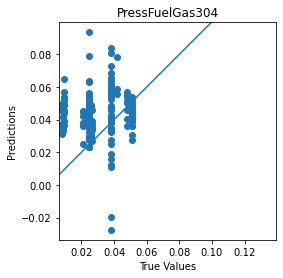

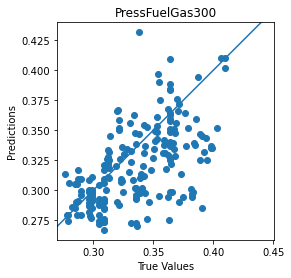

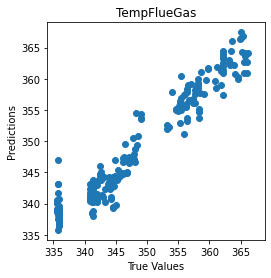

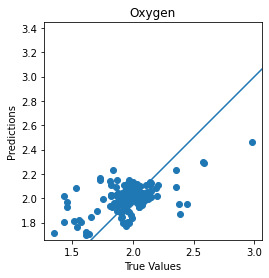

In [30]:
PressFuelGas304_output_pred = Y_pred[0]
PressFuelGas300_output_pred = Y_pred[1]
TempFlueGas_output_pred = Y_pred[2]
Oxygen_output_pred = Y_pred[3]


plot_diff(test_Y[0][:200], Y_pred[0][:200], title='PressFuelGas304')
plot_diff(test_Y[1][:200], Y_pred[1][:200], title='PressFuelGas300')
plot_diff(test_Y[2][:200], Y_pred[2][:200], title='TempFlueGas')
plot_diff(test_Y[3][:200], Y_pred[3][:200], title='Oxygen')

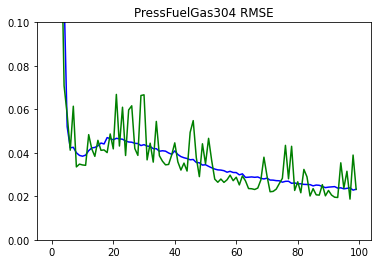

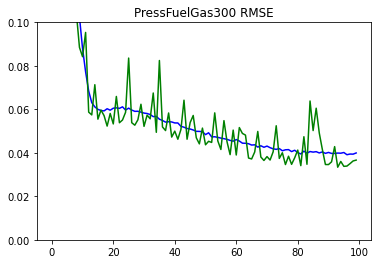

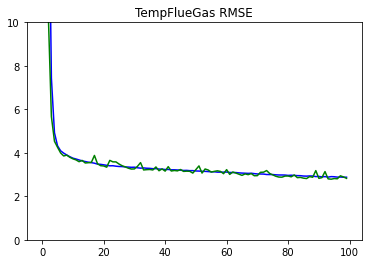

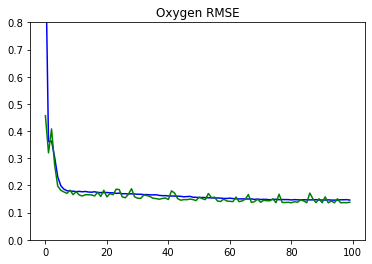

In [31]:
# Plot RMSE
plot_metrics(metric_name='PressFuelGas304_output_root_mean_squared_error', title='PressFuelGas304 RMSE', ylim=0.1)
plot_metrics(metric_name='PressFlueGas300_output_root_mean_squared_error', title='PressFuelGas300 RMSE', ylim=0.1)
plot_metrics(metric_name='TempFlueGas_output_root_mean_squared_error', title='TempFlueGas RMSE', ylim=10)
plot_metrics(metric_name='Oxygen_output_root_mean_squared_error', title='Oxygen RMSE', ylim=0.8)

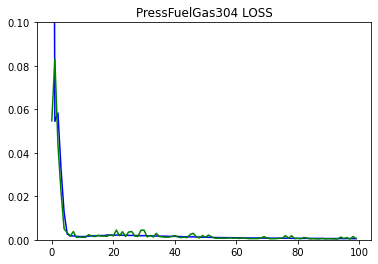

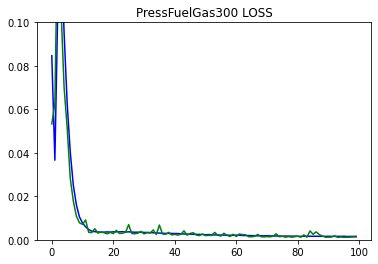

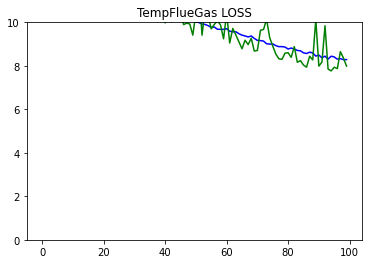

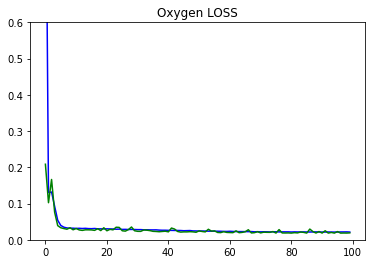

In [32]:
# Plot loss
plot_metrics(metric_name='PressFuelGas304_output_loss', title='PressFuelGas304 LOSS', ylim=(0.1))
plot_metrics(metric_name='PressFlueGas300_output_loss', title='PressFuelGas300 LOSS', ylim=0.1)
plot_metrics(metric_name='TempFlueGas_output_loss', title='TempFlueGas LOSS', ylim=10)
plot_metrics(metric_name='Oxygen_output_loss', title='Oxygen LOSS', ylim=0.6)

In [33]:
dff = df.shift(1)
dff = dff.drop(['Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv','Press Fuel gas/92pi304.pv','Press flue gas/92pi300.pv'], axis=1)

dfff = df.shift(2)
dfff = dfff.drop(['Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv','Press Fuel gas/92pi304.pv','Press flue gas/92pi300.pv'], axis=1)


dffff = df.shift(3)
dffff = dffff.drop(['Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv','Press Fuel gas/92pi304.pv','Press flue gas/92pi300.pv'], axis=1)


dfffff = df.shift(4)
dfffff = dfffff.drop(['Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv','Press Fuel gas/92pi304.pv','Press flue gas/92pi300.pv'], axis=1)

pd.set_option('display.max_columns', None)

new_df = pd.concat([df,dff,dfff,dffff,dfffff], axis=1, ignore_index=True)
new_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Time,,,,,,,,,,,,,,,,,,,,,,,,
2008-06-21 07:00:00,355.848480,352.095337,401.596222,1.123510,0.008244,0.310961,335.989716,2.052690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-21 07:00:01,355.877014,354.608063,401.471863,1.111719,0.008244,0.310964,335.989563,2.030534,355.848480,352.095337,401.596222,1.123510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-21 07:00:02,355.905548,356.111176,401.347473,1.099927,0.008245,0.310968,335.989410,2.018448,355.877014,354.608063,401.471863,1.111719,355.848480,352.095337,401.596222,1.123510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-21 07:00:03,355.934082,356.604675,401.223083,1.088136,0.008245,0.310972,335.989258,2.016434,355.905548,356.111176,401.347473,1.099927,355.877014,354.608063,401.471863,1.111719,355.848480,352.095337,401.596222,1.123510,NaN,NaN,NaN,NaN
2008-06-21 07:00:04,355.962616,355.491791,401.098724,1.083197,0.008246,0.310976,335.989105,2.014420,355.934082,356.604675,401.223083,1.088136,355.905548,356.111176,401.347473,1.099927,355.877014,354.608063,401.471863,1.111719,355.848480,352.095337,401.596222,1.123510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-06-21 12:59:55,355.894012,355.310516,384.652435,1.079072,0.050951,0.317213,355.115173,1.953448,356.169708,358.634003,384.401489,1.071057,356.065216,359.391846,384.150543,1.063042,355.580566,357.584076,383.899628,1.055027,355.095886,355.776306,384.101471,1.052222
2008-06-21 12:59:56,355.618317,354.761658,384.477875,1.083946,0.050951,0.319882,355.113800,1.955882,355.894012,355.310516,384.652435,1.079072,356.169708,358.634003,384.401489,1.071057,356.065216,359.391846,384.150543,1.063042,355.580566,357.584076,383.899628,1.055027
2008-06-21 12:59:57,355.342621,356.987366,383.877808,1.085681,0.050951,0.322551,355.112396,1.958315,355.618317,354.761658,384.477875,1.083946,355.894012,355.310516,384.652435,1.079072,356.169708,358.634003,384.401489,1.071057,356.065216,359.391846,384.150543,1.063042


In [34]:
new_df = new_df.dropna()
display(new_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Time,,,,,,,,,,,,,,,,,,,,,,,,
2008-06-21 07:00:04,355.962616,355.491791,401.098724,1.083197,0.008246,0.310976,335.989105,2.014420,355.934082,356.604675,401.223083,1.088136,355.905548,356.111176,401.347473,1.099927,355.877014,354.608063,401.471863,1.111719,355.848480,352.095337,401.596222,1.123510
2008-06-21 07:00:05,355.991150,352.772614,400.974335,1.085110,0.008246,0.310980,335.988953,2.012406,355.962616,355.491791,401.098724,1.083197,355.934082,356.604675,401.223083,1.088136,355.905548,356.111176,401.347473,1.099927,355.877014,354.608063,401.471863,1.111719
2008-06-21 07:00:06,356.208862,350.053406,400.849976,1.087023,0.008246,0.310984,335.988800,2.010391,355.991150,352.772614,400.974335,1.085110,355.962616,355.491791,401.098724,1.083197,355.934082,356.604675,401.223083,1.088136,355.905548,356.111176,401.347473,1.099927
2008-06-21 07:00:07,356.615753,347.334198,400.725586,1.088937,0.008247,0.310988,335.988647,2.008377,356.208862,350.053406,400.849976,1.087023,355.991150,352.772614,400.974335,1.085110,355.962616,355.491791,401.098724,1.083197,355.934082,356.604675,401.223083,1.088136
2008-06-21 07:00:08,357.022614,347.042145,400.818329,1.090851,0.008247,0.310991,335.988495,1.993103,356.615753,347.334198,400.725586,1.088937,356.208862,350.053406,400.849976,1.087023,355.991150,352.772614,400.974335,1.085110,355.962616,355.491791,401.098724,1.083197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-06-21 12:59:55,355.894012,355.310516,384.652435,1.079072,0.050951,0.317213,355.115173,1.953448,356.169708,358.634003,384.401489,1.071057,356.065216,359.391846,384.150543,1.063042,355.580566,357.584076,383.899628,1.055027,355.095886,355.776306,384.101471,1.052222
2008-06-21 12:59:56,355.618317,354.761658,384.477875,1.083946,0.050951,0.319882,355.113800,1.955882,355.894012,355.310516,384.652435,1.079072,356.169708,358.634003,384.401489,1.071057,356.065216,359.391846,384.150543,1.063042,355.580566,357.584076,383.899628,1.055027
2008-06-21 12:59:57,355.342621,356.987366,383.877808,1.085681,0.050951,0.322551,355.112396,1.958315,355.618317,354.761658,384.477875,1.083946,355.894012,355.310516,384.652435,1.079072,356.169708,358.634003,384.401489,1.071057,356.065216,359.391846,384.150543,1.063042


In [35]:
train, test = train_test_split(new_df, test_size=0.2, random_state = 1)
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [36]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def format_output(data):
    y1 = data.pop( 5)
    y1 = np.array(y1)
    y2 = data.pop( 10)
    y2 = np.array(y2)
    y3 = data.pop( 14)
    y3 = np.array(y3)
    y4 = data.pop( 15)
    y4 = np.array(y4)
    
    return y1, y2, y3, y4

In [37]:
# Get the 4 outputs and format them as np arrays

train_stats = train.describe()
train_stats.pop( 5)
train_stats.pop( 10)
train_stats.pop( 14)
train_stats.pop( 15)
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)
val_Y = format_output(val)

print(train_stats)

      count        mean        std         min         25%         50%  \
0   13763.0  396.022491  45.442905  310.567108  367.370255  378.992737   
1   13763.0  396.802368  44.631638  338.026001  366.665710  376.442230   
2   13763.0  435.139648  43.245937  366.199371  409.854004  419.963837   
3   13763.0    1.378175   0.326648    0.999363    1.171117    1.221851   
4   13763.0    0.029983   0.012617    0.008246    0.024766    0.024766   
6   13763.0  349.244171   9.259828  335.513092  341.958069  346.988800   
7   13763.0    1.995136   0.163647    1.331221    1.930510    1.997299   
8   13763.0  396.004639  45.449036  310.567108  367.363998  378.907135   
9   13763.0  396.807129  44.626450  339.065826  366.590179  376.447266   
11  13763.0    1.378335   0.326687    0.999363    1.171285    1.221934   
12  13763.0  395.992249  45.458969  310.665314  367.331650  378.880280   
13  13763.0  396.817291  44.631916  338.026001  366.604019  376.454803   
16  13763.0  395.981567  45.469181  31

In [38]:
# Normalize the training and test data
norm_train_X = np.array(norm(train))
norm_test_X = np.array(norm(test))
norm_val_X = np.array(norm(val))

In [39]:
model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'PressFuelGas304_output': 'mse', 'PressFlueGas300_output': 'mse','TempFlueGas_output': 'mse','Oxygen_output': 'mse'},
              metrics={'PressFuelGas304_output': tf.keras.metrics.RootMeanSquaredError(),
                       'PressFlueGas300_output': tf.keras.metrics.RootMeanSquaredError(),
                       'TempFlueGas_output': tf.keras.metrics.RootMeanSquaredError(),
                       'Oxygen_output': tf.keras.metrics.RootMeanSquaredError()})
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 128)          2688        ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 64)           8256        ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dense_4[0][0]']                
                                                                                            

In [40]:
# Train the model for 50 epochs
history = model.fit(norm_train_X, train_Y,  
                    epochs=100, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/100
1377/1377 [==============================] - 11s 5ms/step - loss: 190237.5625 - PressFuelGas304_output_loss: 2.1394 - PressFlueGas300_output_loss: 87054.0000 - TempFlueGas_output_loss: 103180.5859 - Oxygen_output_loss: 0.7208 - PressFuelGas304_output_root_mean_squared_error: 1.4627 - PressFlueGas300_output_root_mean_squared_error: 295.0491 - TempFlueGas_output_root_mean_squared_error: 321.2173 - Oxygen_output_root_mean_squared_error: 0.8490 - val_loss: 45684.0078 - val_PressFuelGas304_output_loss: 2.0578 - val_PressFlueGas300_output_loss: 22946.4961 - val_TempFlueGas_output_loss: 22735.0879 - val_Oxygen_output_loss: 0.3969 - val_PressFuelGas304_output_root_mean_squared_error: 1.4345 - val_PressFlueGas300_output_root_mean_squared_error: 151.4810 - val_TempFlueGas_output_root_mean_squared_error: 150.7816 - val_Oxygen_output_root_mean_squared_error: 0.6300
Epoch 2/100
1377/1377 [==============================] - 5s 4ms/step - loss: 37477.6797 - PressFuelGas304_output_loss: 1.1

Epoch 20/100
1377/1377 [==============================] - 6s 4ms/step - loss: 3.0895 - PressFuelGas304_output_loss: 0.0234 - PressFlueGas300_output_loss: 1.4965 - TempFlueGas_output_loss: 1.5634 - Oxygen_output_loss: 0.0062 - PressFuelGas304_output_root_mean_squared_error: 0.1530 - PressFlueGas300_output_root_mean_squared_error: 1.2233 - TempFlueGas_output_root_mean_squared_error: 1.2503 - Oxygen_output_root_mean_squared_error: 0.0788 - val_loss: 2.6296 - val_PressFuelGas304_output_loss: 0.0199 - val_PressFlueGas300_output_loss: 1.2320 - val_TempFlueGas_output_loss: 1.3722 - val_Oxygen_output_loss: 0.0055 - val_PressFuelGas304_output_root_mean_squared_error: 0.1409 - val_PressFlueGas300_output_root_mean_squared_error: 1.1100 - val_TempFlueGas_output_root_mean_squared_error: 1.1714 - val_Oxygen_output_root_mean_squared_error: 0.0742
Epoch 21/100
1377/1377 [==============================] - 6s 4ms/step - loss: 2.8071 - PressFuelGas304_output_loss: 0.0204 - PressFlueGas300_output_loss: 1.

Epoch 30/100
1377/1377 [==============================] - 6s 4ms/step - loss: 1.6545 - PressFuelGas304_output_loss: 0.0101 - PressFlueGas300_output_loss: 0.7640 - TempFlueGas_output_loss: 0.8762 - Oxygen_output_loss: 0.0042 - PressFuelGas304_output_root_mean_squared_error: 0.1007 - PressFlueGas300_output_root_mean_squared_error: 0.8741 - TempFlueGas_output_root_mean_squared_error: 0.9361 - Oxygen_output_root_mean_squared_error: 0.0645 - val_loss: 1.0571 - val_PressFuelGas304_output_loss: 0.0084 - val_PressFlueGas300_output_loss: 0.4491 - val_TempFlueGas_output_loss: 0.5961 - val_Oxygen_output_loss: 0.0034 - val_PressFuelGas304_output_root_mean_squared_error: 0.0918 - val_PressFlueGas300_output_root_mean_squared_error: 0.6702 - val_TempFlueGas_output_root_mean_squared_error: 0.7721 - val_Oxygen_output_root_mean_squared_error: 0.0586
Epoch 31/100
1377/1377 [==============================] - 6s 4ms/step - loss: 1.4743 - PressFuelGas304_output_loss: 0.0096 - PressFlueGas300_output_loss: 0.

Epoch 40/100
1377/1377 [==============================] - 6s 4ms/step - loss: 1.4362 - PressFuelGas304_output_loss: 0.0056 - PressFlueGas300_output_loss: 0.6625 - TempFlueGas_output_loss: 0.7643 - Oxygen_output_loss: 0.0038 - PressFuelGas304_output_root_mean_squared_error: 0.0748 - PressFlueGas300_output_root_mean_squared_error: 0.8140 - TempFlueGas_output_root_mean_squared_error: 0.8742 - Oxygen_output_root_mean_squared_error: 0.0617 - val_loss: 1.9157 - val_PressFuelGas304_output_loss: 0.0063 - val_PressFlueGas300_output_loss: 0.9322 - val_TempFlueGas_output_loss: 0.9743 - val_Oxygen_output_loss: 0.0029 - val_PressFuelGas304_output_root_mean_squared_error: 0.0796 - val_PressFlueGas300_output_root_mean_squared_error: 0.9655 - val_TempFlueGas_output_root_mean_squared_error: 0.9871 - val_Oxygen_output_root_mean_squared_error: 0.0534
Epoch 41/100
1377/1377 [==============================] - 5s 4ms/step - loss: 1.4368 - PressFuelGas304_output_loss: 0.0054 - PressFlueGas300_output_loss: 0.

Epoch 50/100
1377/1377 [==============================] - 5s 4ms/step - loss: 1.1019 - PressFuelGas304_output_loss: 0.0039 - PressFlueGas300_output_loss: 0.5065 - TempFlueGas_output_loss: 0.5884 - Oxygen_output_loss: 0.0031 - PressFuelGas304_output_root_mean_squared_error: 0.0622 - PressFlueGas300_output_root_mean_squared_error: 0.7117 - TempFlueGas_output_root_mean_squared_error: 0.7671 - Oxygen_output_root_mean_squared_error: 0.0560 - val_loss: 1.0165 - val_PressFuelGas304_output_loss: 0.0027 - val_PressFlueGas300_output_loss: 0.4553 - val_TempFlueGas_output_loss: 0.5561 - val_Oxygen_output_loss: 0.0024 - val_PressFuelGas304_output_root_mean_squared_error: 0.0521 - val_PressFlueGas300_output_root_mean_squared_error: 0.6747 - val_TempFlueGas_output_root_mean_squared_error: 0.7457 - val_Oxygen_output_root_mean_squared_error: 0.0486
Epoch 51/100
1377/1377 [==============================] - 5s 4ms/step - loss: 1.1703 - PressFuelGas304_output_loss: 0.0040 - PressFlueGas300_output_loss: 0.

Epoch 60/100
1377/1377 [==============================] - 5s 4ms/step - loss: 1.0742 - PressFuelGas304_output_loss: 0.0032 - PressFlueGas300_output_loss: 0.5171 - TempFlueGas_output_loss: 0.5510 - Oxygen_output_loss: 0.0029 - PressFuelGas304_output_root_mean_squared_error: 0.0568 - PressFlueGas300_output_root_mean_squared_error: 0.7191 - TempFlueGas_output_root_mean_squared_error: 0.7423 - Oxygen_output_root_mean_squared_error: 0.0539 - val_loss: 0.7124 - val_PressFuelGas304_output_loss: 0.0021 - val_PressFlueGas300_output_loss: 0.2751 - val_TempFlueGas_output_loss: 0.4307 - val_Oxygen_output_loss: 0.0044 - val_PressFuelGas304_output_root_mean_squared_error: 0.0464 - val_PressFlueGas300_output_root_mean_squared_error: 0.5245 - val_TempFlueGas_output_root_mean_squared_error: 0.6563 - val_Oxygen_output_root_mean_squared_error: 0.0664
Epoch 61/100
1377/1377 [==============================] - 5s 4ms/step - loss: 1.0263 - PressFuelGas304_output_loss: 0.0032 - PressFlueGas300_output_loss: 0.

Epoch 70/100
1377/1377 [==============================] - 6s 4ms/step - loss: 1.2188 - PressFuelGas304_output_loss: 0.0027 - PressFlueGas300_output_loss: 0.5882 - TempFlueGas_output_loss: 0.6254 - Oxygen_output_loss: 0.0025 - PressFuelGas304_output_root_mean_squared_error: 0.0522 - PressFlueGas300_output_root_mean_squared_error: 0.7669 - TempFlueGas_output_root_mean_squared_error: 0.7909 - Oxygen_output_root_mean_squared_error: 0.0497 - val_loss: 2.8869 - val_PressFuelGas304_output_loss: 0.0019 - val_PressFlueGas300_output_loss: 1.5110 - val_TempFlueGas_output_loss: 1.3722 - val_Oxygen_output_loss: 0.0018 - val_PressFuelGas304_output_root_mean_squared_error: 0.0431 - val_PressFlueGas300_output_root_mean_squared_error: 1.2292 - val_TempFlueGas_output_root_mean_squared_error: 1.1714 - val_Oxygen_output_root_mean_squared_error: 0.0419
Epoch 71/100
1377/1377 [==============================] - 5s 4ms/step - loss: 1.2162 - PressFuelGas304_output_loss: 0.0028 - PressFlueGas300_output_loss: 0.

Epoch 80/100
1377/1377 [==============================] - 6s 4ms/step - loss: 1.0253 - PressFuelGas304_output_loss: 0.0024 - PressFlueGas300_output_loss: 0.4861 - TempFlueGas_output_loss: 0.5346 - Oxygen_output_loss: 0.0023 - PressFuelGas304_output_root_mean_squared_error: 0.0486 - PressFlueGas300_output_root_mean_squared_error: 0.6972 - TempFlueGas_output_root_mean_squared_error: 0.7312 - Oxygen_output_root_mean_squared_error: 0.0482 - val_loss: 2.6820 - val_PressFuelGas304_output_loss: 0.0020 - val_PressFlueGas300_output_loss: 1.3300 - val_TempFlueGas_output_loss: 1.3472 - val_Oxygen_output_loss: 0.0029 - val_PressFuelGas304_output_root_mean_squared_error: 0.0442 - val_PressFlueGas300_output_root_mean_squared_error: 1.1533 - val_TempFlueGas_output_root_mean_squared_error: 1.1607 - val_Oxygen_output_root_mean_squared_error: 0.0534
Epoch 81/100
1377/1377 [==============================] - 5s 4ms/step - loss: 1.1717 - PressFuelGas304_output_loss: 0.0024 - PressFlueGas300_output_loss: 0.

Epoch 90/100
1377/1377 [==============================] - 6s 4ms/step - loss: 0.9668 - PressFuelGas304_output_loss: 0.0020 - PressFlueGas300_output_loss: 0.4733 - TempFlueGas_output_loss: 0.4895 - Oxygen_output_loss: 0.0020 - PressFuelGas304_output_root_mean_squared_error: 0.0449 - PressFlueGas300_output_root_mean_squared_error: 0.6880 - TempFlueGas_output_root_mean_squared_error: 0.6996 - Oxygen_output_root_mean_squared_error: 0.0451 - val_loss: 0.5851 - val_PressFuelGas304_output_loss: 0.0018 - val_PressFlueGas300_output_loss: 0.2737 - val_TempFlueGas_output_loss: 0.3077 - val_Oxygen_output_loss: 0.0018 - val_PressFuelGas304_output_root_mean_squared_error: 0.0425 - val_PressFlueGas300_output_root_mean_squared_error: 0.5232 - val_TempFlueGas_output_root_mean_squared_error: 0.5547 - val_Oxygen_output_root_mean_squared_error: 0.0430
Epoch 91/100
1377/1377 [==============================] - 5s 4ms/step - loss: 1.0352 - PressFuelGas304_output_loss: 0.0021 - PressFlueGas300_output_loss: 0.

Epoch 100/100
1377/1377 [==============================] - 6s 4ms/step - loss: 0.9054 - PressFuelGas304_output_loss: 0.0018 - PressFlueGas300_output_loss: 0.4272 - TempFlueGas_output_loss: 0.4744 - Oxygen_output_loss: 0.0019 - PressFuelGas304_output_root_mean_squared_error: 0.0430 - PressFlueGas300_output_root_mean_squared_error: 0.6536 - TempFlueGas_output_root_mean_squared_error: 0.6888 - Oxygen_output_root_mean_squared_error: 0.0439 - val_loss: 0.7832 - val_PressFuelGas304_output_loss: 0.0026 - val_PressFlueGas300_output_loss: 0.3684 - val_TempFlueGas_output_loss: 0.4103 - val_Oxygen_output_loss: 0.0020 - val_PressFuelGas304_output_root_mean_squared_error: 0.0506 - val_PressFlueGas300_output_root_mean_squared_error: 0.6070 - val_TempFlueGas_output_root_mean_squared_error: 0.6405 - val_Oxygen_output_root_mean_squared_error: 0.0445


# Results of the model with timesteps

In [41]:
# Test the model and print loss and rmse for ALL outputs
loss, Y1_loss, Y2_loss,Y3_loss, Y4_loss, Y1_rmse, Y2_rmse, Y3_rmse, Y4_rmse = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'PressFuelGas304_loss: {Y1_loss}')
print(f'PressFlueGas300_loss: {Y2_loss}')
print(f'TempFlueGas_loss: {Y3_loss}')
print(f'Oxygen_loss: {Y4_loss}')
print(f'PressFuelGas304_rmse: {Y1_rmse}')
print(f'PressFlueGas300_rmse: {Y2_rmse}')
print(f'TempFlueGas_rmse: {Y3_rmse}')
print(f'Oxygen_rmse: {Y4_rmse}')

108/108 [==============================] - 0s 3ms/step - loss: 0.7431 - PressFuelGas304_output_loss: 0.0026 - PressFlueGas300_output_loss: 0.3571 - TempFlueGas_output_loss: 0.3814 - Oxygen_output_loss: 0.0020 - PressFuelGas304_output_root_mean_squared_error: 0.0511 - PressFlueGas300_output_root_mean_squared_error: 0.5976 - TempFlueGas_output_root_mean_squared_error: 0.6176 - Oxygen_output_root_mean_squared_error: 0.0444

loss: 0.7431237697601318
PressFuelGas304_loss: 0.002612059935927391
PressFlueGas300_loss: 0.35712671279907227
TempFlueGas_loss: 0.38141655921936035
Oxygen_loss: 0.0019683658611029387
PressFuelGas304_rmse: 0.05110831558704376
PressFlueGas300_rmse: 0.5976008176803589
TempFlueGas_rmse: 0.6175892949104309
Oxygen_rmse: 0.044366270303726196
